<span style="font-size:3em;">Ch7: Telling birds from airplanes: Learning from images </span>

In this chapter, we’ll keep moving ahead with building our neural network foundations. This time, we’ll turn our attention to images. Image recognition is arguably the task that made the world realize the potential of deep learning.


# 7.1 A dataset of tiny images

We will use a dataset called CIFAR-10, and, like its sibling CIFAR-100, it has been a computer vision classic for a decade. CIFAR-10 consists of 60,000 tiny 32 × 32 color (RGB) images, labeled with an integer corresponding to 1 of 10 classes: airplane (0), automobile (1), bird (2), cat (3),
deer (4), dog (5), frog (6), horse (7), ship (8), and truck (9).

Nowadays, CIFAR-10 is
considered too simple for developing or validating new research, but it serves our
learning purposes just fine. We will use the torchvision module to automatically
download the dataset and load it as a collection of PyTorch tensors.

## 7.1.1 Downloading CIFAR-10

The first argument we provide to the CIFAR10 function is the location from which the
data will be downloaded; the second specifies whether we’re interested in the training
set or the validation set; and the third says whether we allow PyTorch to download the
data if it is not found in the location specified in the first argument.
 Just like CIFAR10, the datasets submodule gives us precanned access to the most
popular computer vision datasets, such as MNIST, Fashion-MNIST, CIFAR-100,
SVHN, Coco, and Omniglot. In each case, the dataset is returned as a subclass of
torch.utils.data.Dataset. 

In [174]:
import torch
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

In [120]:
data_path = '../data-unversioned/p1ch7/' #this is where we will download the data too
cifar10 = datasets.CIFAR10(data_path, train=True, download=True) #instantiates a training dataset 
cifar10_val = datasets.CIFAR10(data_path,train=False, download=True) #train=False gives us the validation set

0.0%

100.0%

Extracting ../data-unversioned/p1ch7/cifar-10-python.tar.gz to ../data-unversioned/p1ch7/
Files already downloaded and verified


In [121]:
#We can see that the Method resolution order of our cifar10 instanec includes it as a base class
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 object)

## 7.1.2 The Dataset Class

It’s a good time to discover what being a subclass of torch.utils.data.Dataset
means in practice

 It
is an object that is required to implement two methods: __len__ and __getitem__.
The former should return the number of items in the dataset; the latter should return
the item, consisting of a sample and its corresponding label (an integer index).2
 In practice, when a Python object is equipped with the __len__ method, we can
pass it as an argument to the len Python built-in function:

In [122]:
len(cifar10)

50000

Similarly, since the dataset is equipped with the __getitem__ method, we can use the
standard subscript for indexing tuples and lists to access individual items. Here, we get
a PIL (Python Imaging Library, the PIL package) image with our desired output—an
integer with the value 1, corresponding to “automobile”:

In [124]:
img, label = cifar10[99]
img,label

(<PIL.Image.Image image mode=RGB size=32x32 at 0x11C94E910>, 1)

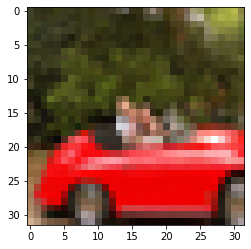

In [126]:
#We can plot these images
plt.imshow(img);

## 7.1.3 Dataset transforms

That’s all very nice, but we’ll likely need a way to convert the PIL image to a PyTorch
tensor before we can do anything with it. That’s where torchvision.transforms
comes in. This module defines a set of composable, function-like objects that can be
passed as an argument to a torchvision dataset such as datasets.CIFAR10(…), and
that perform transformations on the data after it is loaded but before it is returned by
  __ getitem __ 
  
  
Here are some of the transforms

In [127]:
from torchvision import transforms
dir(transforms)

['CenterCrop',
 'ColorJitter',
 'Compose',
 'FiveCrop',
 'Grayscale',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'Pad',
 'RandomAffine',
 'RandomApply',
 'RandomChoice',
 'RandomCrop',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomOrder',
 'RandomPerspective',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'functional',
 'transforms']

Among those transforms, we can spot ToTensor, which turns NumPy arrays and PIL
images to tensors. It also takes care to lay out the dimensions of the output tensor as
C × H × W (channel, height, width; just as we covered in chapter 4).

 Let’s try out the ToTensor transform. Once instantiated, it can be called like a
function with the PIL image as the argument, returning a tensor as output:

In [128]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

The image has been turned into a 3 × 32 × 32 tensor and therefore a 3-channel (RGB)
32 × 32 image. Note that nothing has happened to label; it is still an integer.


 As we anticipated, we can pass the transform directly as an argument to dataset
.CIFAR10:

In [129]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                                 transform=transforms.ToTensor())

In [132]:
#Now our images will come out as tensors
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [133]:
#As expected CxHxW and float 32
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

Whereas the values in the original PIL image ranged from 0 to 255 (8 bits per channel), the ToTensor transform turns the data into a 32-bit floating-point per channel,
scaling the values down from 0.0 to 1.0. 

Let’s verify that:

In [134]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

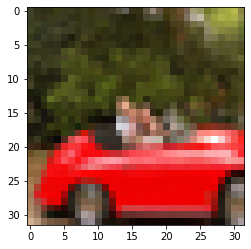

In [135]:
#Lets verify its the same image, note we need to change the axis
plt.imshow(img_t.permute(1,2,0));

## 7.1.4 Normalizing data

Transforms are really handy because we can chain them using transforms.Compose,
and they can handle normalization and data augmentation transparently, directly in
the data loader. For instance, it’s good practice to normalize the dataset so that each
channel has zero mean and unitary standard deviation. We mentioned this in chapter
4, but now, after going through chapter 5, we also have an intuition for why: by choosing
activation functions that are linear around 0 plus or minus 1 (or 2), keeping the data
in the same range means it’s more likely that neurons have nonzero gradients and, hence will learn faster

Also, normalizing each channel so that it has the same
distribution will ensure that channel information can be mixed and updated through
gradient descent using the same learning rate. This is just like the situation in section
5.4.4 when we rescaled the weight to be of the same magnitude as the bias in our
temperature-conversion model.


 In order to make it so that each channel has zero mean and unitary standard deviation, we can compute the mean value and the standard deviation of each channel
across the dataset and apply the following transform: v_n[c] = (v[c] - mean[c]) /
stdev[c]. This is what transforms.Normalize does. The values of mean and stdev
must be computed offline (they are not computed by the transform).


__Since CIFAR is small, we can manipulate it entirely in memory__

In [136]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

Recall that view(3, -1) keeps the three channels and
merges all the remaining dimensions into one, figuring
out the appropriate size. Here our 3 × 32 × 32 image is
transformed into a 3 × 1,024 vector, and then the mean
is taken over the 1,024 elements of each channel.

In [138]:
#Now we can easily compute the mean per channel and std
means = imgs.view(3,-1).mean(dim=1)

stds = imgs.view(3,-1).std(dim=1)

means, stds

(tensor([0.4915, 0.4823, 0.4468]), tensor([0.2470, 0.2435, 0.2616]))

In [139]:
#With these numbers we can now normalize our channels
transforms.Normalize((0.4915, 0.4823, 0.4468),(0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))

In [140]:
#now we just need to add it when instantiating our dataset
transformed_CIFAR = datasets.CIFAR10(data_path, train=True, download=False,
                                    transform=transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                             (0.2470, 0.2435, 0.2616))
                                    ]))

Note that, at this point, plotting an image drawn from the dataset won’t provide us
with a faithful representation of the actual image:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


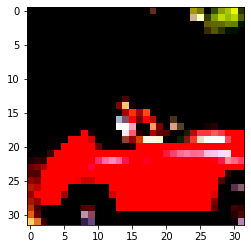

In [142]:
img_t, _ = transformed_CIFAR[99]
plt.imshow(img_t.permute(1,2,0))

 This is because normalization
has shifted the RGB levels outside the 0.0 to 1.0 range and changed the overall magnitudes of the channels. All of the data is still there; it’s just that Matplotlib renders it as
black. We’ll keep this in mind for the future.

# 7.2 Distinguishing birds from airplanes
 We’ll pick out all the birds and airplanes from our
CIFAR-10 dataset and build a neural network that can tell birds and airplanes apart.

## 7.2.1 Building the Dataset

The first step is to get the data in the right shape. We could create a Dataset subclass
that only includes birds and airplanes. However, the dataset is small, and we only need
indexing and len to work on our dataset. It doesn’t actually have to be a subclass of
torch.utils.data.dataset.Dataset! Well, why not take a shortcut and just filter the
data in cifar10 and remap the labels so they are contiguous? Here’s how:

In [158]:
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [159]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [160]:
label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0,2]]

cifar2_val = [(img, label_map[label]) for img,label in cifar10_val if label in [0,2]]

The cifar2 object satisfies the basic requirements for a Dataset—that is, __len__ and
__getitem__ are defined—so we’re going to use that. We should be aware, however,
that this is a clever shortcut and we might wish to implement a proper Dataset if we
hit limitations with it.4

## 7.2.2 A Fully Connected Model

In [145]:
32*32*3

3072

In [146]:
#Lets build a model
n_out = 2

model = nn.Sequential(
                    nn.Linear(3072, 512), #Use 3072 since we flatten the image(32*32*3 = 3072)
                    nn.Tanh(),
                    nn.Linear(512, n_out)
                    )

## 7.2.3 Output of a classifier

We need to recognize that the output is categorical: The key realization in this case is that we can interpret our output as probabilities: the
first entry is the probability of “airplane,” and the second is the probability of “bird.”
 Casting the problem in terms of probabilities imposes a few extra constraints on
the outputs of our network:
- Each element of the output must be in the [0.0, 1.0] range (a probability of
an outcome cannot be less than 0 or greater than 1).
- The elements of the output must add up to 1.0 (we’re certain that one of the
two outcomes will occur).

The solution is a simple and differentiable activation called __Softmax__

## 7.2.4 Representing the output as probabilities
Softmax is a function that takes a vector of values and produces another vector of the
same dimension, where the values satisfy the constraints we just listed to represent
probabilities.

In [148]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [151]:
x = torch.tensor([1.,2.,3.])
softmax(x), softmax(x).sum()

(tensor([0.0900, 0.2447, 0.6652]), tensor(1.))

Softmax is a monotone function, in that lower values in the input will correspond to
lower values in the output. However, it’s not scale invariant, in that the ratio between
values is not preserved. In fact, the ratio between the first and second elements of the
input is 0.5, while the ratio between the same elements in the output is 0.3678. This is
not a real issue, since the learning process will drive the parameters of the model in a
way that values have appropriate ratios.

Can call softmax in pytorch using __nn.Softmax()__

 Since, as usual, input tensors
may have an additional batch 0th dimension, or have dimensions along which they
encode probabilities and others in which they don’t, nn.Softmax requires us to specify
the dimension along which the softmax function is applied:

In [154]:
softmax = nn.Softmax(dim=1)
x = torch.tensor([[1.,2.,3.],
                [1.,2.,3.]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [155]:
#Now we can add softmax to our model
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512,2),
            nn.Softmax(dim=1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


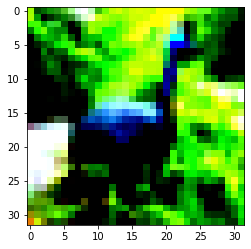

In [162]:
#Lets try out our model before we train
img, _ = cifar2[0]
plt.imshow(img.permute(1,2,0))

 We recall that our model expects 3,072 features in the input, and that nn
works with data organized into batches along the zeroth dimension. So we need to
turn our 3 × 32 × 32 image into a 1D tensor and then add an extra dimension in the
zeroth position. 

In [167]:
img_batch = img.view(-1).unsqueeze(0)

In [169]:
#Now lets use the model
out = model(img_batch)
out

tensor([[0.4678, 0.5322]], grad_fn=<SoftmaxBackward>)

We got probabilities but they are random guesses since our model isnt trained yet.


Interestingly, we also see grad_fn for the
output, which is the tip of the backward computation graph (it will be used as soon as
we need to backpropagate)

 In addition, while we know which output probability is supposed to be which
(recall our class_names), our network has no indication of that. Is the first entry “airplane” and the second “bird,” or the other way around? The network can’t even tell
that at this point. It’s the loss function that associates a meaning with these two numbers, after backpropagation. If the labels are provided as index 0 for “airplane” and
index 1 for “bird,” then that’s the order the outputs will be induced to take. Thus,
after training, we will be able to get the label as an index by computing the argmax of
the output probabilities: that is, the index at which we get the maximum probability.
Conveniently, when supplied with a dimension, torch.max returns the maximum element along that dimension as well as the index at which that value occurs. In our case,
we need to take the max along the probability vector (not across batches), therefore,
dimension 1:

In [171]:
_, index = torch.max(out, dim=1)
index

tensor([1])

## 7.2.5 A loss for classifying

 We could still use MSE and make our
output probabilities converge to [0.0, 1.0] and [1.0, 0.0]. However, thinking about
it, we’re not really interested in reproducing these values exactly. Looking back at the
argmax operation we used to extract the index of the predicted class, what we’re really
interested in is that the first probability is higher than the second for airplanes and vice
versa for birds. In other words, we want to penalize misclassifications rather than painstakingly penalize everything that doesn’t look exactly like a 0.0 or 1.0.

 What we need to maximize in this case is the probability associated with the correct
class, out[class_index], where out is the output of softmax and class_index is a vector containing 0 for “airplane” and 1 for “bird” for each sample. This quantity—that
is, the probability associated with the correct class—is referred to as the likelihood (of
our model’s parameters, given the data).8
 In other words, we want a loss function that
is very high when the likelihood is low: so low that the alternatives have a higher probability. Conversely, the loss should be low when the likelihood is higher than the alternatives, and we’re not really fixated on driving the probability up to 1.

There’s a loss function that behaves that way, and it’s called __negative log likelihood
(NLL)__. It has the expression __NLL = - sum(log(out_i[c_i]))__, where the sum is taken
over N samples and c_i is the correct class for sample i.


 when low probabilities are assigned to the data, the NLL grows
to infinity, whereas it decreases at a rather shallow rate when probabilities are greater
than 0.5. Remember that the NLL takes probabilities as input; so, as the likelihood
grows, the other probabilities will necessarily decrease.

So, how do we do this in PyTorch? 

PyTorch has an __nn.NLLLoss class__. However, as opposed to what you might expect, it does not take probabilities but rather takes a tensor of log probabilities as input. It then computes the NLL of our model given the batch of data. There’s a good reason behind the input convention: taking the logarithm of a probability is tricky when the probability gets close to zero. __The workaround is to use nn.LogSoftmax instead of nn.Softmax__, which takes care to make the calculation numerically stable

In [172]:
model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

loss = nn.NLLLoss()

In [173]:
#Now we can test the NLLLoss on our model
img, label = cifar2[0]
out = model(img.view(-1).unsqueeze(0))

loss(out, torch.tensor([label]))

tensor(0.5032, grad_fn=<NllLossBackward>)

## 7.2.6 Training the classifier

In [ ]:
model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))
learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr= learning_rate)

loss_fn = nn.NLLLoss()

epochs = 10

for epoch in range(epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

 By shuffling samples at each epoch and estimating the gradient on one or (preferably, for stability) a few
samples at a time, we are effectively introducing randomness in our gradient descent.
It turns out that following gradients estimated over minibatches, which are poorer approximations of gradients
estimated across the whole dataset, helps convergence and prevents the optimization
process from getting stuck in local minima it encounters along the way.


Typically, minibatches are a constant size that we need to set prior to training, just
like the learning rate. These are called hyperparameters, to distinguish them from the
parameters of a model.

 The torch.utils.data module has a class that helps with shuffling and
organizing the data in minibatches: DataLoader. The job of a data loader is to sample
minibatches from a dataset, giving us the flexibility to choose from different sampling
strategies. A very common strategy is uniform sampling after shuffling the data at each
epoch.


Let’s see how this is done. At a minimum, the DataLoader constructor takes a Dataset
object as input, along with batch_size and a shuffle Boolean that indicates whether
the data needs to be shuffled at the beginning of each epoch:

In [177]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [179]:
#A dataloader can be iterated over so we can use it in our loop
model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))
learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr= learning_rate)

loss_fn = nn.NLLLoss()

epochs = 10

for epoch in range(epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size,-1))
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("Epoch: %d, Loss: %f" % (epoch, float(loss))) #due to shuffling it prints loss for random batch 

Epoch: 0, Loss: 0.432117
Epoch: 1, Loss: 0.379650
Epoch: 2, Loss: 0.352264
Epoch: 3, Loss: 0.434213
Epoch: 4, Loss: 0.456035
Epoch: 5, Loss: 0.351303
Epoch: 6, Loss: 0.304718
Epoch: 7, Loss: 0.376707
Epoch: 8, Loss: 0.551254
Epoch: 9, Loss: 0.120805


We see that the loss decreases somehow, but we have no idea whether it’s low enough.
Since our goal here is to correctly assign classes to images, and preferably do that on
an independent dataset, we can compute the accuracy of our model on the validation
set in terms of the number of correct classifications over the total:

In [180]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size,-1))
        _, predicted = torch.max(outputs,dim=1)
        total+=labels.shape[0]
        correct += int((predicted == labels).sum())

In [182]:
total, correct

(2000, 1630)

Not a great performance, but quite a lot better than random. In our defense, our
model was quite a shallow classifier; lets try something a bit more complex

In [183]:
model = nn.Sequential(
        nn.Linear(3072, 1024),
        nn.Tanh(),
        nn.Linear(1024, 512),
        nn.Tanh(),
        nn.Linear(512, 128),
        nn.Tanh(),
        nn.Linear(128, 2),
        nn.LogSoftmax(dim=1))

The combination of nn.LogSoftmax and nn.NLLLoss is equivalent to using
nn.CrossEntropyLoss. This terminology is a particularity of PyTorch, as the
nn.NLLoss computes, in fact, the cross entropy but with log probability predictions as
inputs where nn.CrossEntropyLoss takes scores (sometimes called logits). Technically, nn.NLLLoss is the cross entropy between the Dirac distribution, putting all mass
on the target, and the predicted distribution given by the log probability inputs.
 
 
 To add to the confusion, in information theory, up to normalization by sample size,
this cross entropy can be interpreted as a negative log likelihood of the predicted distribution under the target distribution as an outcome. So both losses are the negative
log likelihood of the model parameters given the data when our model predicts the
(softmax-applied) probabilities. In this book, we won’t rely on these details, but don’t
let the PyTorch naming confuse you when you see the terms used in the literature.
 It is quite common to drop the last nn.LogSoftmax layer from the network and use
nn.CrossEntropyLoss as a loss

In [184]:
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

loss_fn = nn.CrossEntropyLoss()

Note that the numbers will be exactly the same as with nn.LogSoftmax and nn.NLLLoss.
It’s just more convenient to do it all in one pass, with the only gotcha being that the output of our model will not be interpretable as probabilities (or log probabilities). We’ll
need to explicitly pass the output through a softmax to obtain those.

Training this model and evaluating the accuracy on the validation set (0.802000)
lets us appreciate that a larger model bought us an increase in accuracy, but not that
much. The accuracy on the training set is practically perfect (0.998100). What is this
telling us? That we are overfitting our model in both cases. Our fully connected
model is finding a way to discriminate birds and airplanes on the training set by memorizing the training set, but performance on the validation set is not all that great,
even if we choose a larger mode

To find out how many elements are in each tensor
instance, we can call the numel method. Summing those gives us our total count.
Depending on our use case, counting parameters might require us to check whether a
parameter has requires_grad set to True, as well. We might want to differentiate the
number of trainable parameters from the overall model size. Let’s take a look at what
we have right now:

In [185]:
numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True]

sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

What is this telling us? That our neural network won’t scale very well with the number
of pixels. What if we had a 1,024 × 1,024 RGB image? That’s 3.1 million input values.
Even abruptly going to 1,024 hidden features (which is not going to work for our classifier), we would have over 3 billion parameters. Using 32-bit floats, we’re already at 12
GB of RAM, and we haven’t even hit the second layer, much less computed and stored
the gradients. That’s just not going to fit on most present-day GPUs.


## 7.2.7 The limits of going fully connected
 On one hand, we are allowing for the combination of any pixel with every other pixel in the image being potentially relevant for our
task. On the other hand, we aren’t utilizing the relative position of neighboring or faraway pixels, since we are treating the image as one big vector of numbers

A fully connected network is not translation invariant. This means a
network that has been trained to recognize a Spitfire starting at position 4,4 will not
be able to recognize the exact same Spitfire starting at position 8,8. We would then have
to augment the dataset—that is, apply random translations to images during training—
so the network would have a chance to see Spitfires all over the image, and we would
need to do this for every image in the dataset  However, this data
augmentation strategy comes at a cost: the number of hidden features—that is, of
parameters—must be large enough to store the information about all of these translated replicas